In [26]:
!pip install pandas seaborn matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

In [28]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (891, 12)
Test shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [29]:
# Info about dataset-->
print(train.info())

# Summary statistics -->
train.describe(include="all").T

# Missing values count-->
print("\nMissing values per column:\n")
print(train.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Missing values per column:

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
E

In [30]:
# Copy to not lose original
train_clean = train.copy()

# HasCabin feature to treat Cabin nulls
train_clean['HasCabin'] = train_clean['Cabin'].notna().astype(int)

# Extract Title from Name to handle Age nulls
train_clean['Title'] = train_clean['Name'].str.extract(r',\s*([^\.]+)\.', expand=False).str.strip()

# Group some rare titles
title_map = {
    'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
    'Lady':'Rare', 'Countess':'Rare', 'Capt':'Rare', 'Col':'Rare',
    'Don':'Rare', 'Dr':'Rare', 'Major':'Rare', 'Rev':'Rare', 
    'Sir':'Rare', 'Jonkheer':'Rare', 'Dona':'Rare', 'the Countess':'Rare'
}
train_clean['Title'] = train_clean['Title'].replace(title_map)

# Fill missing Age with median by Title
title_ages = train_clean.groupby('Title')['Age'].median()
train_clean['Age'] = train_clean.apply(
    lambda row: title_ages[row['Title']] if pd.isna(row['Age']) else row['Age'],
    axis=1
)

# Fill missing Embarked with mode
train_clean['Embarked'] = train_clean['Embarked'].fillna(train_clean['Embarked'].mode()[0])

# Check again
print(train_clean['Title'].unique())
print(train_clean.isna().sum())


['Mr' 'Mrs' 'Miss' 'Master' 'Rare']
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
HasCabin         0
Title            0
dtype: int64


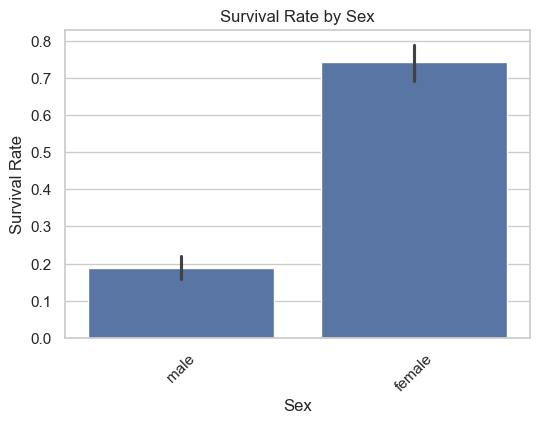

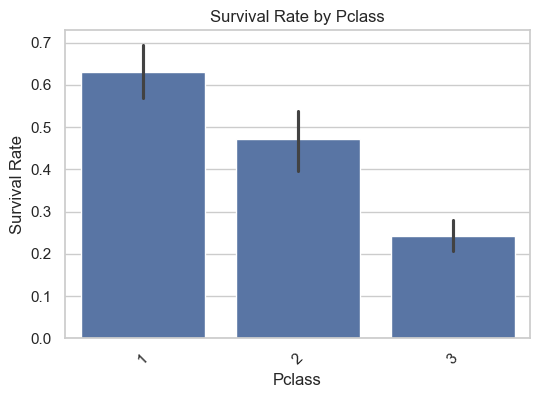

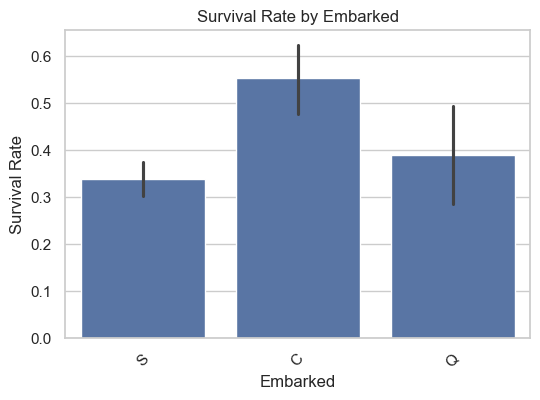

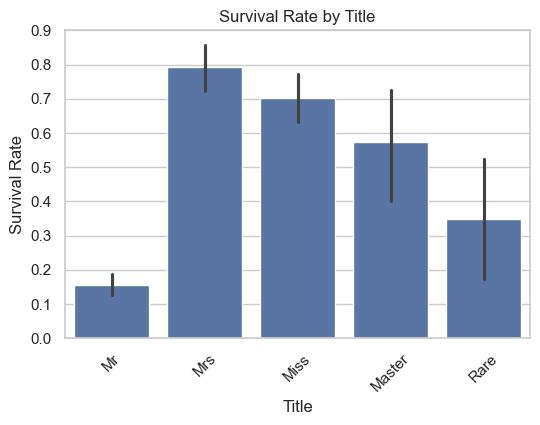

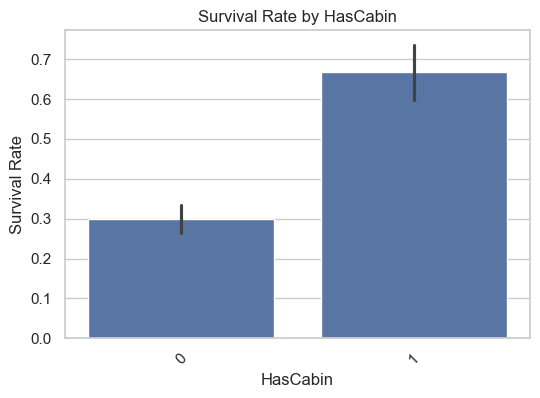

In [31]:
# Bar plots: Survival rate by categorical variables
categorical_features = ['Sex', 'Pclass', 'Embarked', 'Title', 'HasCabin']

for col in categorical_features:
    plt.figure(figsize=(6,4))
    sns.barplot(x=col, y='Survived', data=train_clean, estimator=lambda x: sum(x)/len(x))
    plt.title(f"Survival Rate by {col}")
    plt.ylabel("Survival Rate")
    plt.xticks(rotation=45)
    plt.show()


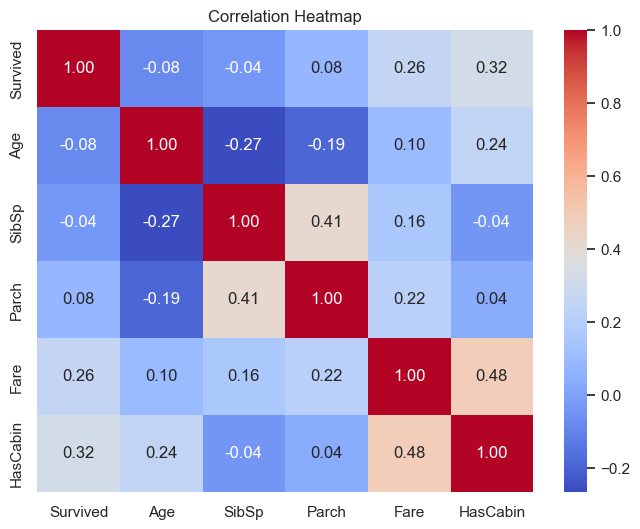

In [60]:
# Correlation heatmap 
plt.figure(figsize=(8,6))
sns.heatmap(
    train_clean[['Survived','Age','SibSp','Parch','Fare','HasCabin']].corr(),
    annot=True, cmap="coolwarm", fmt=".2f"
)
plt.title("Correlation Heatmap")
plt.show()


In [59]:
#  Encode Sex
train_clean['Sex'] = train_clean['Sex'].map({'male': 0, 'female': 1})

# Embarked and Title
if 'Embarked' in train_clean.columns and 'Title' in train_clean.columns:
    train_clean = pd.get_dummies(train_clean, columns=['Embarked','Title'], drop_first=True)

# FamilySize & IsAlone
train_clean['FamilySize'] = train_clean['SibSp'] + train_clean['Parch'] + 1
train_clean['IsAlone'] = (train_clean['FamilySize'] == 1).astype(int)

# Drop irrelevant cols 
train_clean = train_clean.drop(['PassengerId','Name','Ticket','Cabin'], axis=1, errors='ignore')


In [34]:
print(train_clean.columns)


Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'HasCabin', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Rare', 'FamilySize', 'IsAlone'],
      dtype='object')


In [35]:
pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [45]:
X = train_clean.drop('Survived', axis=1)
y = train_clean['Survived']

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)


Training set shape: (712, 15)
Validation set shape: (179, 15)


In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_val, y_pred))
    print("-" * 40)

# tell best model
best_model_name = max(results, key=results.get)
print(f"Best model: {best_model_name} with accuracy {results[best_model_name]:.4f}")


C:\Users\pc\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.8268
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       110
           1       0.79      0.75      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

----------------------------------------
Decision Tree Accuracy: 0.7765
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       110
           1       0.72      0.70      0.71        69

    accuracy                           0.78       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.78      0.78      0.78       179

----------------------------------------
Random Forest Accuracy: 0.7765
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       110
           1       0.70      0.72      0.71        69

 

In [57]:
#  again from original train dataframe
train_titles = train.copy()
train_titles['Title'] = train_titles['Name'].str.extract(r',\s*([^\.]+)\.', expand=False).str.strip()

# Map rare titles same as old
title_map = {
    'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
    'Lady':'Rare','Countess':'Rare','Capt':'Rare','Col':'Rare',
    'Don':'Rare','Dr':'Rare','Major':'Rare','Rev':'Rare',
    'Sir':'Rare','Jonkheer':'Rare','Dona':'Rare', 'the Countess' :'Rare'
}
train_titles['Title'] = train_titles['Title'].replace(title_map)

# Median ages by title
title_age_medians = train_titles.groupby('Title')['Age'].median()
print(title_age_medians)


Title
Master     3.5
Miss      21.0
Mr        30.0
Mrs       35.0
Rare      48.5
Name: Age, dtype: float64


In [56]:
def preprocess(df):
    df = df.copy()

    # HasCabin
    df['HasCabin'] = df['Cabin'].notna().astype(int)

    # Extract Title
    df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False).str.strip()
    title_map = {
        'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
        'Lady':'Rare','Countess':'Rare','Capt':'Rare','Col':'Rare',
        'Don':'Rare','Dr':'Rare','Major':'Rare','Rev':'Rare',
        'Sir':'Rare','Jonkheer':'Rare','Dona':'Rare'
    }
    df['Title'] = df['Title'].replace(title_map)

    # Fill missing Age using precomputed medians from train
    df['Age'] = df.apply(
        lambda row: title_age_medians[row['Title']]
        if pd.isna(row['Age']) and row['Title'] in title_age_medians else row['Age'],
        axis=1
    )

    # Fill Embarked 
    if 'Embarked' in df.columns:
        df['Embarked'] = df['Embarked'].fillna(train['Embarked'].mode()[0])

    # Fill Fare
    df['Fare'] = df['Fare'].fillna(train['Fare'].median())

    # Encode Sex
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

    # Dumm
    df = pd.get_dummies(df, columns=['Embarked', 'Title'], drop_first=True)

    # Fam
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    df = df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1, errors='ignore')

    return df


In [40]:
test_clean = preprocess(test)
print(test_clean.shape)
print(test_clean.head())


(418, 15)
   Pclass  Sex   Age  SibSp  Parch     Fare  HasCabin  Embarked_Q  Embarked_S  \
0       3    0  34.5      0      0   7.8292         0        True       False   
1       3    1  47.0      1      0   7.0000         0       False        True   
2       2    0  62.0      0      0   9.6875         0        True       False   
3       3    0  27.0      0      0   8.6625         0       False        True   
4       3    1  22.0      1      1  12.2875         0       False        True   

   Title_Miss  Title_Mr  Title_Mrs  Title_Rare  FamilySize  IsAlone  
0       False      True      False       False           1        1  
1       False     False       True       False           2        0  
2       False      True      False       False           1        1  
3       False      True      False       False           1        1  
4       False     False       True       False           3        0  


In [41]:
test_clean = test_clean.astype(int)


In [55]:
missing_cols = set(X.columns) - set(test_clean.columns)
for col in missing_cols:
    test_clean[col] = 0

test_clean = test_clean[X.columns]


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

log_reg = LogisticRegression(max_iter=1000)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

log_reg.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)

log_reg_acc = log_reg.score(X_val, y_val)
dt_acc = dt.score(X_val, y_val)
rf_acc = rf.score(X_val, y_val)

print("Logistic Regression Accuracy:", log_reg_acc)
print("Decision Tree Accuracy:", dt_acc)
print("Random Forest Accuracy:", rf_acc)

best_model = log_reg  # based on previous results


Logistic Regression Accuracy: 0.8268156424581006
Decision Tree Accuracy: 0.776536312849162
Random Forest Accuracy: 0.776536312849162


In [53]:
test_predictions = best_model.predict(test_clean)
print(test_predictions[:20])  # checkinggg first 20 predictions


[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1]
